In [2]:
import os
import glob
from sklearn import preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
dataset_path = os.path.join('faces')  # path to the dataset

# function to plot the images
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [4]:
# get the total number of images
total_images = 0
for image_file in glob.glob(os.path.join(dataset_path, '*.jpeg')):
    total_images += 1

print(f"Total images: {total_images}")

Total images: 1687


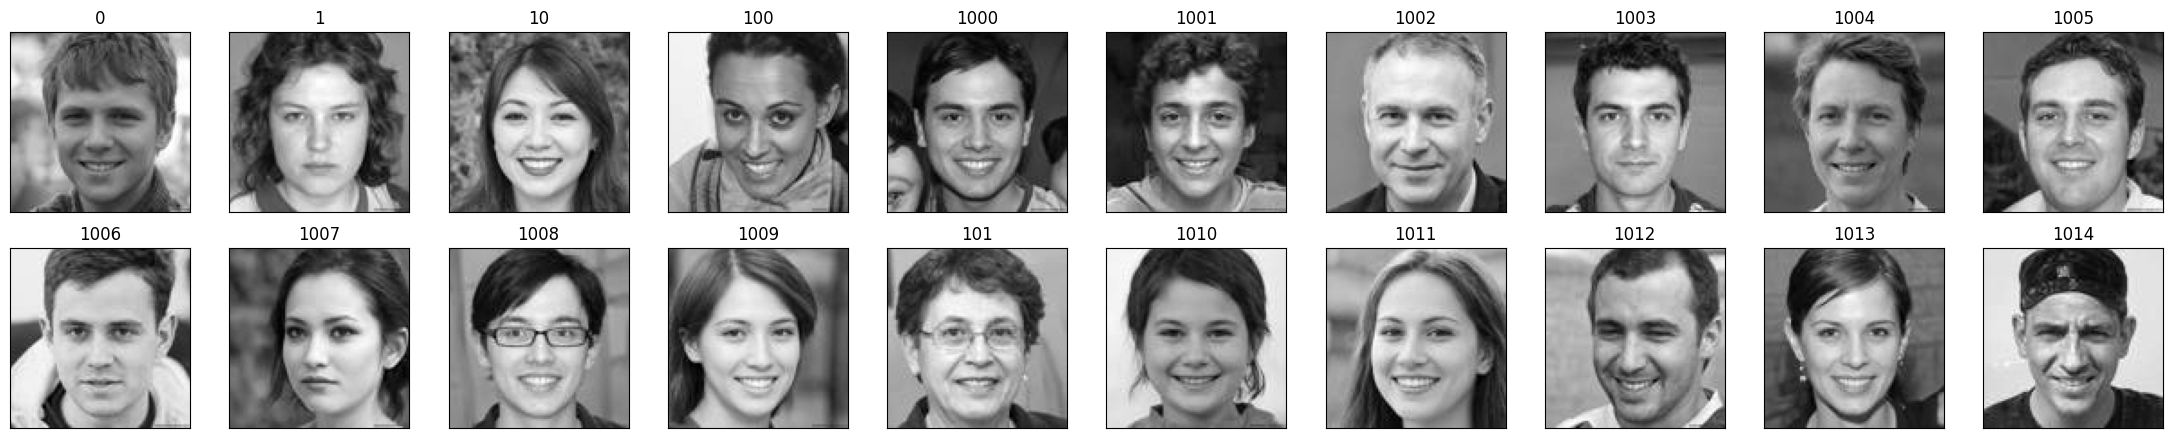

In [5]:
shape = (100, 100)  # size of the images
all_images = np.zeros((total_images, shape[0], shape[1]), dtype='float64')  # initialize the numpy array
names = []
i = 0
for image_file in glob.glob(os.path.join(dataset_path, '*.jpeg')):
    names.append(os.path.basename(image_file)[:-5])  # get the filename without extension
    read_image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)  # read the image in grayscale
    resized_image = cv2.resize(read_image, (shape[1], shape[0]))  # cv2.resize resizes an image into (# column x # height)
    if i < total_images:
        all_images[i] = np.array(resized_image)
    i += 1

plot_portraits(all_images, names, 100, 100, 2, 10)  # plot 20 of the images

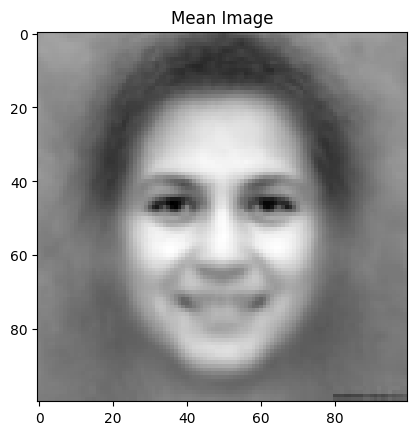

In [6]:
A = np.resize(all_images, (total_images, shape[0]*shape[1])) #convert the images into vectors. Each row has an image vector. i.e. samples x image_vector matrix
mean_vector = np.sum(A, axis=0, dtype='float64')/total_images #calculate the mean vector
mean_matrix = np.tile(mean_vector, (total_images, 1)) #make a 400 copy of the same vector. 400 x image_vector_size matrix.
A_tilde = A - mean_matrix #mean-subtracted image vectors
plt.imshow(np.resize(mean_vector, (shape[0],shape[1])), cmap='gray') #show the mean image vector
plt.title('Mean Image')
plt.show()

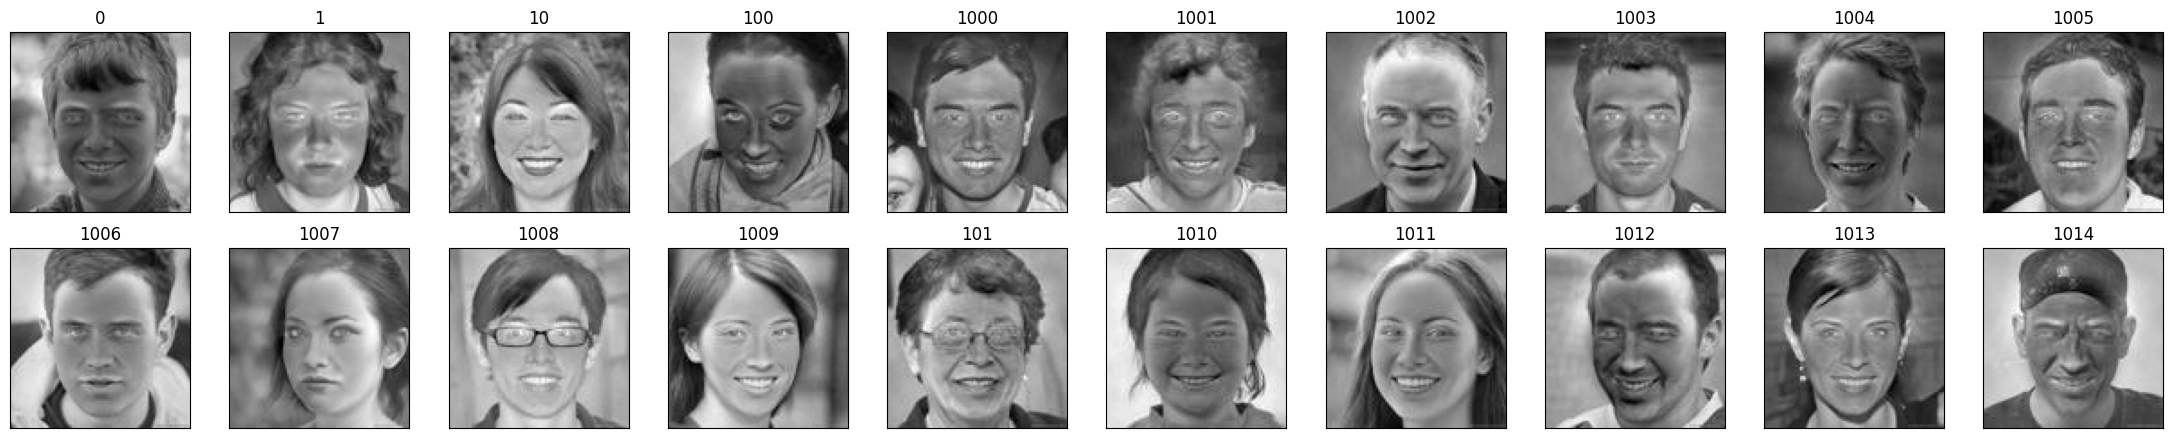

In [7]:
plot_portraits(A_tilde, names, 100,100, 2, 10) # matrix A_tilde that contains vectors of each mean subtracted img

In [8]:
L = (A_tilde.dot(A_tilde.T))/total_images #since each row is an image vector and we want to find the covariance matrix, we multiply A_tilde with its transpose.
print("L shape : ", L.shape)
eigenvalues, eigenvectors = np.linalg.eig(L) #find the eigenvalues and the eigenvectors of L
idx = eigenvalues.argsort()[::-1] #get the indices of the eigenvalues by its value. Descending order.
eigenvalues = eigenvalues[idx] 
eigenvectors = eigenvectors[:, idx] #sorted eigenvalues and eigenvectors in descending order
eigenvectors_C = A_tilde.T @ eigenvectors #linear combination of each column of A_tilde
eigenvectors_C.shape #each column is an eigenvector of C where C = (A_tilde.T)(A_tilde). Eigenvectors of C are the eigenvectors of L
#normalize the eigenvectors
eigenfaces = preprocessing.normalize(eigenvectors_C.T) #normalize only accepts matrix with n_samples, n_feature. Hence the transpose.
eigenfaces.shape

L shape :  (1687, 1687)


(1687, 10000)

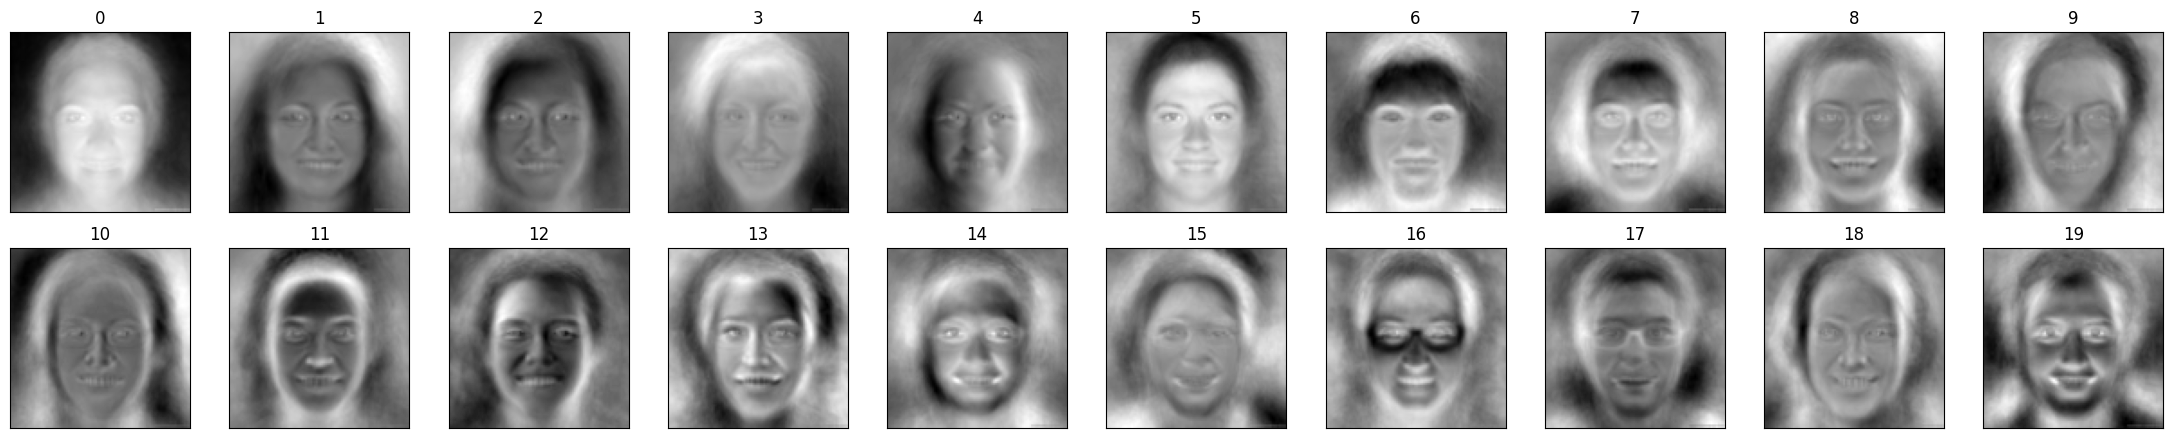

In [9]:
#to visualize some of the eigenfaces
eigenface_labels = [x for x in range(eigenfaces.shape[0])] #list containing values from 1 to number of eigenfaces
plot_portraits(eigenfaces, eigenface_labels , 100,100, 2, 10) 

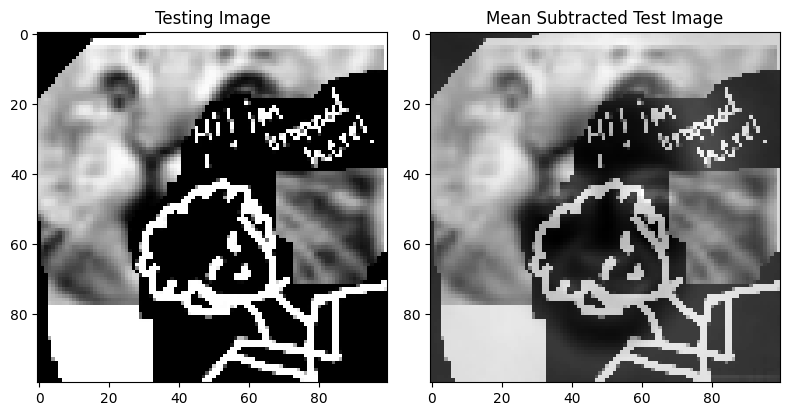

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

test_img = cv2.imread('testimg/2.jpeg', cv2.IMREAD_GRAYSCALE) #testing image
test_img = cv2.resize(test_img, (shape[1],shape[0])) #resize the testing image. cv2 resize by width and height.
axs[0].imshow(np.reshape(test_img, (100,100)), cmap='gray')
axs[0].set_title("Testing Image")
mean_subracted_testimg = np.reshape(test_img, (test_img.shape[0]*test_img.shape[1])) - mean_vector #subtract the mean
axs[1].imshow(np.reshape(mean_subracted_testimg, (100,100)), cmap='gray')
axs[1].set_title("Mean Subtracted Test Image")

plt.tight_layout()
plt.show()

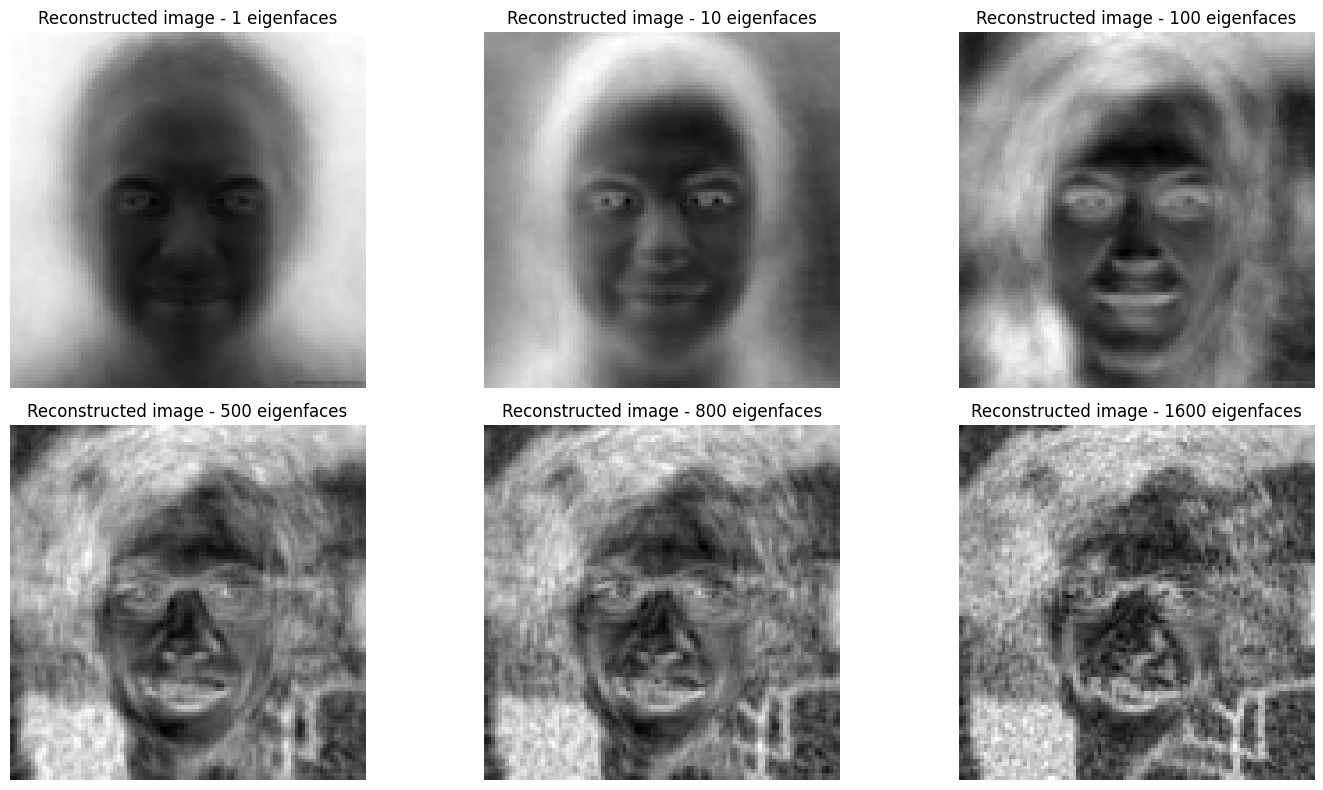

In [24]:
num_eigenfaces = [1, 10, 100, 500, 800, 1600]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i, q in enumerate(num_eigenfaces):
    omega = eigenfaces[:q].dot(mean_subracted_testimg)  # the vector that represents the image with respect to the eigenfaces.
    reconstructed = eigenfaces[:q].T.dot(omega)  # image reconstructed using q eigenfaces.
    
    axs[i].imshow(np.reshape(reconstructed, (shape[0], shape[1])), cmap='gray')
    axs[i].set_title(f"Reconstructed image - {q} eigenfaces")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [25]:
alpha_1 = 3000 #chosen threshold for face detection

projected_new_img_vector = eigenfaces[:q].T @ omega #n^2 vector of the new face image represented as the linear combination of the chosen eigenfaces
diff = mean_subracted_testimg - projected_new_img_vector 
beta = math.sqrt(diff.dot(diff)) #distance between the original face image vector and the projected vector.

if beta < alpha_1:
    print("Face detected in the image! ", beta)
else:
    print("No face detected in the image! ", beta)

No face detected in the image!  5218.705902099763


In [54]:
alpha_2 = 3000 #chosen threshold for face recognition
smallest_value = None #to keep track of the smallest value
index = None #to keep track of the class that produces the smallest value
for k in range(total_images):
    omega_k = eigenfaces[:q].dot(A_tilde[k]) #calculate the vectors of the images in the dataset and represent 
    diff = omega - omega_k
    epsilon_k = math.sqrt(diff.dot(diff))
    if smallest_value == None:
        smallest_value = epsilon_k
        index = k
    if smallest_value > epsilon_k:
        smallest_value = epsilon_k
        index = k
        
if smallest_value < alpha_2:
    print(smallest_value, names[index])
else:
    print(smallest_value, "Unknown Face!")

4178.977220094003 Unknown Face!
